In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

In [2]:
# Define dataset directory
dataset_dir = r"C:\Users\postb\OneDrive\Desktop\Capstone Projects\AI\Xray\chest_xray"  # Update this to your dataset path
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

In [3]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


In [5]:
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


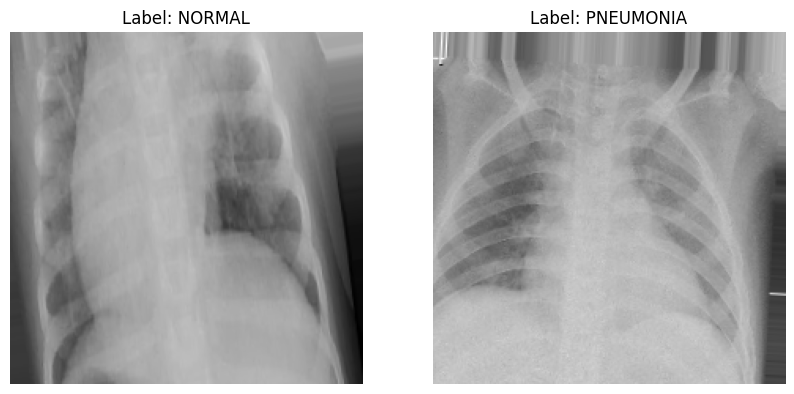

In [6]:
# View Sample Data from Each Label
class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(1, len(class_labels), figsize=(10, 5))
for i, label in enumerate(class_labels):
    batch = next(train_generator)
    img, lbl = batch[0][0], batch[1][0]
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()


In [7]:
# Load Pretrained Model (VGG16)
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
    

In [8]:
# Build Transfer Learning Model
x = Flatten()(vgg16.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)
model = Model(inputs=vgg16.input, outputs=out)


In [9]:

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [10]:
# Train Model
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

c:\Users\postb\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - accuracy: 0.8580 - loss: 0.3088 - val_accuracy: 0.9375 - val_loss: 0.2413
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.9424 - loss: 0.1462 - val_accuracy: 0.8750 - val_loss: 0.2008
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - accuracy: 0.9503 - loss: 0.1299 - val_accuracy: 0.8750 - val_loss: 0.1851
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 0.9585 - loss: 0.1165 - val_accuracy: 0.7500 - val_loss: 0.4344
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 612s 4s/step - accuracy: 0.9705 - loss: 0.0883 - val_accuracy: 0.9375 - val_loss: 0.1933
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 599s 4s/step - accuracy: 0.9612 - loss: 0.1024 - val_accuracy: 0.6875 - val_loss: 0.4204
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.9623 - loss: 0.0934 - val_accuracy: 0.7500 - val_loss: 0.3510
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.9671 - loss: 0.0922 - val_accu

In [11]:
# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")



20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8902 - loss: 0.3608
Test Accuracy: 0.9151


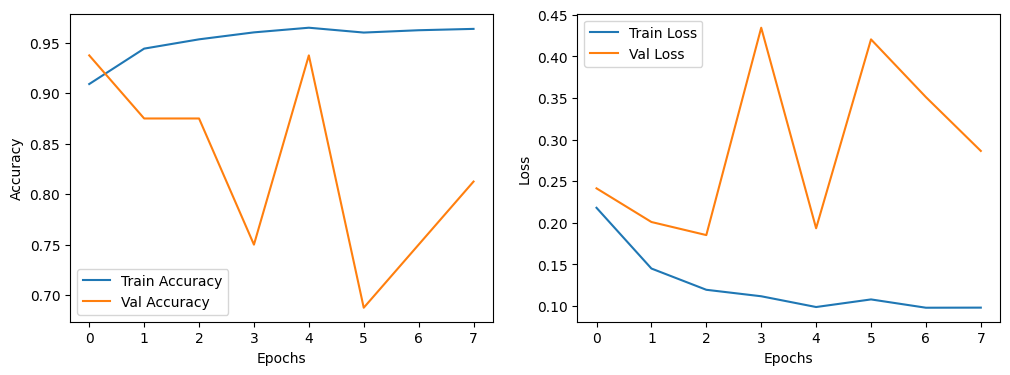

In [12]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [28]:
# Test with a Random Image from the Test Set
random_index = random.randint(0, len(test_generator.filenames) - 1)
random_image_path = os.path.join(test_dir, test_generator.filenames[random_index])
random_image = tf.keras.preprocessing.image.load_img(random_image_path, target_size=IMG_SIZE)
random_image_array = tf.keras.preprocessing.image.img_to_array(random_image) / 255.0
random_image_array = np.expand_dims(random_image_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


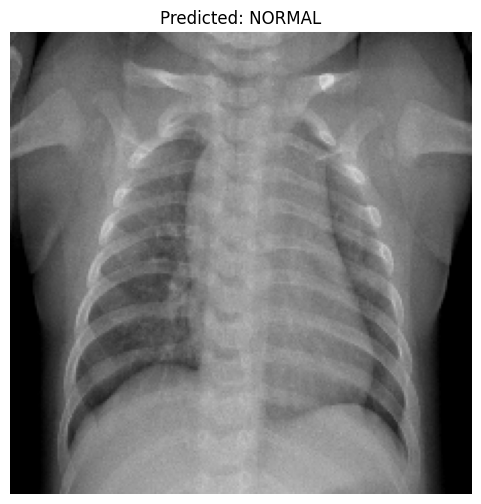

In [27]:
# Predict
prediction = model.predict(random_image_array)
predicted_label = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"

# Display Image and Prediction
plt.figure(figsize=(6, 6))
plt.imshow(random_image)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()
